## Imports

In [1]:
import pandas as pd
import glob
import os


# Import data
filename = 'outputs/results/combined_enterprise_output.csv'

df = pd.read_csv(filename)


# Filter only unknown vendors
#print(df['Vendor'])
unknown_vendors = df[df['Vendor'] == 'unknown']
#print(unknown_vendors)
# Group by MAC and count occurrences
mac_counts = unknown_vendors.groupby('Enterprise Code')['IP'].agg(['count', list]).sort_values('count', ascending=False)

# Rename columns for clarity
mac_counts.columns = ['Count', 'IPs']

# print(f"Total IPs with unknown vendors: {len(unknown_vendors)}")
# print("\nMAC addresses and their counts for unknown vendors:")
# print(mac_counts)

# Merge rows for Brocade
df['Vendor'] = df['Vendor'].replace(
    "Brocade Communication Systems, Inc. (formerly 'Foundry Networks, Inc.')",
    "Brocade Communications Systems, Inc."
)

# Filter vendors in case we need more filtering 
excluded_vendors_file = "config/excluded_vendors.txt"
with open(excluded_vendors_file, 'r', encoding='utf-8') as file:
    excluded_vendors = {line.strip() for line in file if line.strip()}

# Convert engine time (seconds) to datetime relative to current time
df['Engine_Age'] = pd.Timestamp.now() - pd.to_timedelta(df['Engine Time'], unit='s')
# Filter out rows with engine time before 1998
df = df[df['Engine_Age'].dt.year >= 1998]
#print(df['Engine_Age'])

size_before = df.shape[0]
print(excluded_vendors)
df = df[~df["Vendor"].isin(excluded_vendors)]
df = df[df["Vendor"] != 'unknown']
print("Dropped " + str(size_before - df.shape[0]) + " by vendor exclusion.\n" + str(df.shape[0]) + " entries left.")
print(df.columns)

{'ciscoSystems', 'net-snmp', 'Brocade Communications Systems, Inc.', 'Juniper Networks, Inc.', 'Ambit Microsystems Corporation', 'HUAWEI Technology Co.,Ltd'}
Dropped 3897 by vendor exclusion.
3480 entries left.
Index(['IP', 'Enterprise Code', 'MAC', 'Engine Time', 'Engine Boots', 'Vendor',
       'Scan Date', 'Reboot Date', 'Engine_Age'],
      dtype='object')


### Popular Vendors:


Vendor Counts:
Vendor
Thomson Inc.                         1008
Arista networks                       730
H3C                                   436
Fortinet, Inc.                        262
Nokia (formerly 'Alcatel-Lucent')     251
SonicWALL, Inc.                       154
Broadcom Limited                       70
Compaq                                 55
Hewlett-Packard                        52
The FreeBSD Project                    37
Name: count, dtype: int64


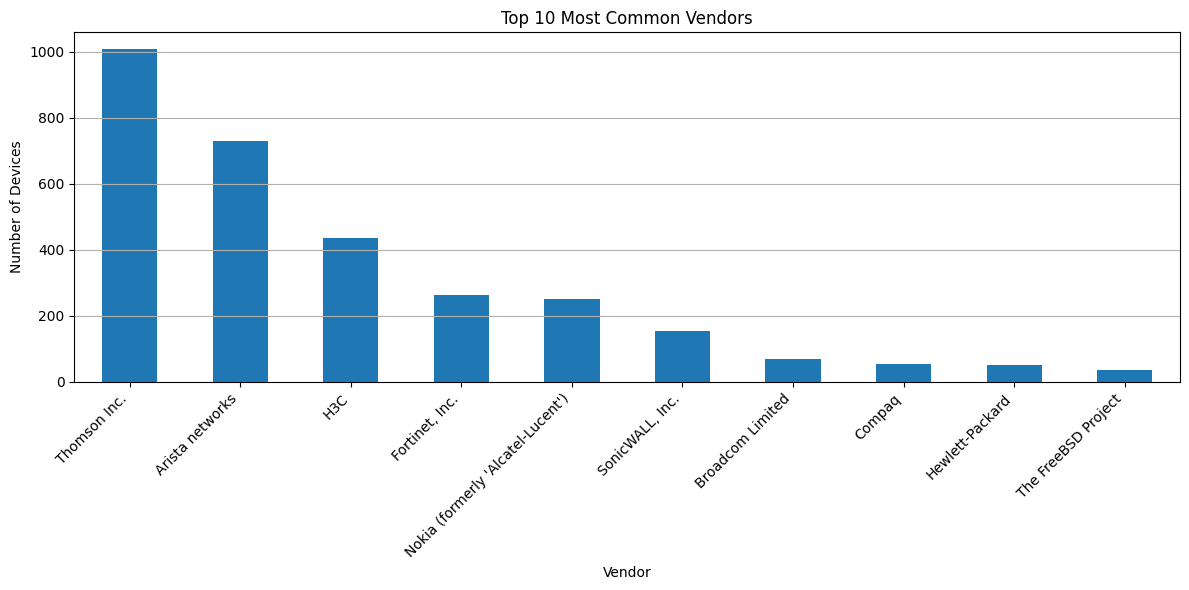

In [2]:
import matplotlib.pyplot as plt

# Get top 10 vendors by count
vendor_counts = df['Vendor'].value_counts().head(10)

# Create bar plot
plt.figure(figsize=(12, 6))
vendor_counts.plot(kind='bar')
plt.title('Top 10 Most Common Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()

# Print exact counts
print("\nVendor Counts:")
print(vendor_counts)

### Fetch CVEs for vendor:

In [3]:
import datetime
from cve_matching import translate_vendor, fetch_CVEs_with_split

# Fetch CVEs for vendor
vendor = "Arista networks"#NetScreen Technologies, Inc.'#SonicWALL, Inc.'Fortinet, Inc.'
max_engine_time = df[df["Vendor"] == vendor]["Engine Time"].max()
latest_reboot_date = max(df["Reboot Date"], key=lambda x: datetime.datetime.strptime(x, "%m_%d_%Y_%H_%M_%S"))
latest_reboot_datetime = datetime.datetime.strptime(latest_reboot_date, "%m_%d_%Y_%H_%M_%S")
print(latest_reboot_datetime)
translated_vendor = translate_vendor(vendor)
cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=latest_reboot_datetime)
print(translated_vendor)
print("Largest Engine Time for", vendor, ":", max_engine_time)
print("Number of CVEs found:", len(cves))

2025-06-06 14:29:20
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
 arista
Largest Engine Time for Arista networks : 193605560.0
Number of CVEs found: 63


### Vulnerable IPs over time:

C:\Users\ipat\AppData\Local\Temp\ipykernel_13780\3750287573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


2019-04-15 22:22:03
Average number of CVEs affecting each device: 28.88
Average CVSS score for all CVEs: 7.10


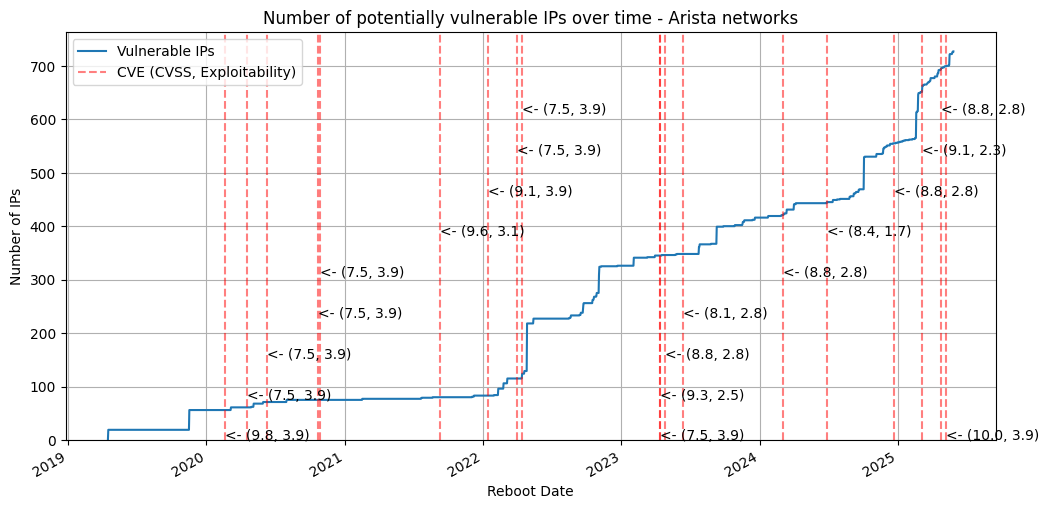

In [4]:
import matplotlib.pyplot as plt

# Convert reboot dates to datetime
# Filter dataframe for specified vendor
df_filtered = df[df['Vendor'] == vendor]
df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_filtered = df_filtered[df_filtered['Reboot_Datetime'].dt.year >= 1998]

# Create time series of vulnerability counts
print(df_filtered['Reboot_Datetime'].min())
time_range = pd.date_range(start=df_filtered['Reboot_Datetime'].min(), end=df_filtered['Reboot_Datetime'].max(), freq='D')
vulnerable_counts = []

for time_point in time_range:
    # Count IPs with reboot time older than this date (vulnerable)
    vulnerable_ips = df_filtered[df_filtered['Reboot_Datetime'] <= time_point]['IP'].nunique()
    vulnerable_counts.append(vulnerable_ips)

# Create and plot the time series
vulnerability_ts = pd.Series(vulnerable_counts, index=time_range)
vulnerability_ts.plot(figsize=(12, 6))
plt.title(f'Number of potentially vulnerable IPs over time - Arista networks')
plt.xlabel('Reboot Date')
plt.ylabel('Number of IPs')
plt.grid(True)
plt.ylim(bottom=0)  # Force y-axis to start at 0

start_date = df_filtered['Reboot_Datetime'].min()
end_date = df_filtered['Reboot_Datetime'].max()

for _, cve in cves.iterrows():
    cve_id = cve['CVE_ID']
    published_str = cve['Published']
    cve_date = pd.to_datetime(published_str).normalize()

# Create a dictionary to store highest scoring CVE per date
cve_highest_scores = {}
for _, cve in cves.iterrows():
    cve_date = pd.to_datetime(cve['Published']).normalize()
    if cve['CVSS_Score'] > 7.4 and cve['Exploitablity_Score'] > 0:
        if cve_date >= start_date and cve_date <= end_date:
            current_score = cve['CVSS_Score'] + cve['Exploitablity_Score']
            if cve_date not in cve_highest_scores or current_score > cve_highest_scores[cve_date]['score']:
                cve_highest_scores[cve_date] = {
                    'score': current_score,
                    'cvss': cve['CVSS_Score'],
                    'exploitability': cve['Exploitablity_Score']
                }

# Plot the highest scoring CVE per date
i = 0
for cve_date, scores in cve_highest_scores.items():
    plt.axvline(x=cve_date, color='r', linestyle='--', alpha=0.5)
    text_height = plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * (0.1 * (i % 9))
    plt.text(cve_date, text_height, f'<- ({scores["cvss"]:.1f}, {scores["exploitability"]:.1f})', 
             horizontalalignment='left', alpha=1)
    i += 1
plt.legend(['Vulnerable IPs', 'CVE (CVSS, Exploitability)'])

# For each device, count CVEs published after its reboot date
cve_dates = pd.to_datetime(cves['Published']).dt.normalize()
device_cve_counts = []
for _, row in df_filtered.iterrows():
    reboot_date = row['Reboot_Datetime']
    # Count CVEs published after reboot date
    num_cves = (cve_dates > reboot_date).sum()
    device_cve_counts.append(num_cves)


average_cves_per_device = sum(device_cve_counts) / len(device_cve_counts) if device_cve_counts else 0
print(f"Average number of CVEs affecting each device: {average_cves_per_device:.2f}")

# Calculate and print the average CVSS score for all CVEs
average_cvss_score = cves['CVSS_Score'].mean()
print(f"Average CVSS score for all CVEs: {average_cvss_score:.2f}")

In [6]:

vendors = ["Arista networks", "Fortinet, Inc.", "SonicWALL, Inc.", "WatchGuard Technologies Inc.", "Aruba, a Hewlett Packard Enterprise company"]
vendor_cves = {}

df_interest = df[df['Vendor'].isin(vendors)]
df_interest['Reboot_Datetime'] = pd.to_datetime(df['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_interest = df_interest[df_interest['Reboot_Datetime'].dt.year >= 1998]

for v in vendors:
    max_engine_time = df_interest[df_interest["Vendor"] == vendor]["Engine Time"].max()
    latest_reboot_date = max(df_interest["Reboot Date"], key=lambda x: datetime.datetime.strptime(x, "%m_%d_%Y_%H_%M_%S"))
    latest_reboot_datetime = datetime.datetime.strptime(latest_reboot_date, "%m_%d_%Y_%H_%M_%S")
    translated_vendor = translate_vendor(v)
    print(max_engine_time)
    print(latest_reboot_datetime)
    cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=latest_reboot_datetime)
    print(v)
    if pd.isna(max_engine_time):
        vendor_cves[v] = None
        continue

    vendor_cves[v] = cves

for v, cves_df in vendor_cves.items():
    print(f"\nVendor: {v}")
    if cves_df is not None:
        print(f"Number of CVEs: {len(cves_df)}")
    else:
        print("No data available.")

C:\Users\ipat\AppData\Local\Temp\ipykernel_13780\3481903171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interest['Reboot_Datetime'] = pd.to_datetime(df['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


193605560.0
2025-06-03 20:10:38
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
Arista networks
193605560.0
2025-06-03 20:10:38
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
Fortinet, Inc.
193605560.0
2025-06-03 20:10:38
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
SonicWALL, Inc.
193605560.0
2025-06-03 20:10:38
fetch
fetch
fetch
Error: 429
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetc

c:\LocalProjects\HackingLab-SNMP\cve_matching.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(results, ignore_index=True) if results else pd.DataFrame()


fetch
fetch
fetch
fetch
Error: 429
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
fetch
Aruba, a Hewlett Packard Enterprise company

Vendor: Arista networks
Number of CVEs: 63

Vendor: Fortinet, Inc.
Number of CVEs: 356

Vendor: SonicWALL, Inc.
Number of CVEs: 82

Vendor: WatchGuard Technologies Inc.
Number of CVEs: 37

Vendor: Aruba, a Hewlett Packard Enterprise company
Number of CVEs: 359


Vulnerable IPs per vendor:
Arista networks: [730, 700, 651]
Fortinet, Inc.: [237, 147, 126]
SonicWALL, Inc.: [70, 23, 18]
WatchGuard Technologies Inc.: [2, 1, 0]
Thomson Inc.: [0, 0, 0]
Aruba, a Hewlett Packard Enterprise company: [12, 12, 7]

Total IPs per vendor:
Arista networks: 730
Fortinet, Inc.: 262
SonicWALL, Inc.: 154
WatchGuard Technologies Inc.: 18
Thomson Inc.: 1008
Aruba: 37


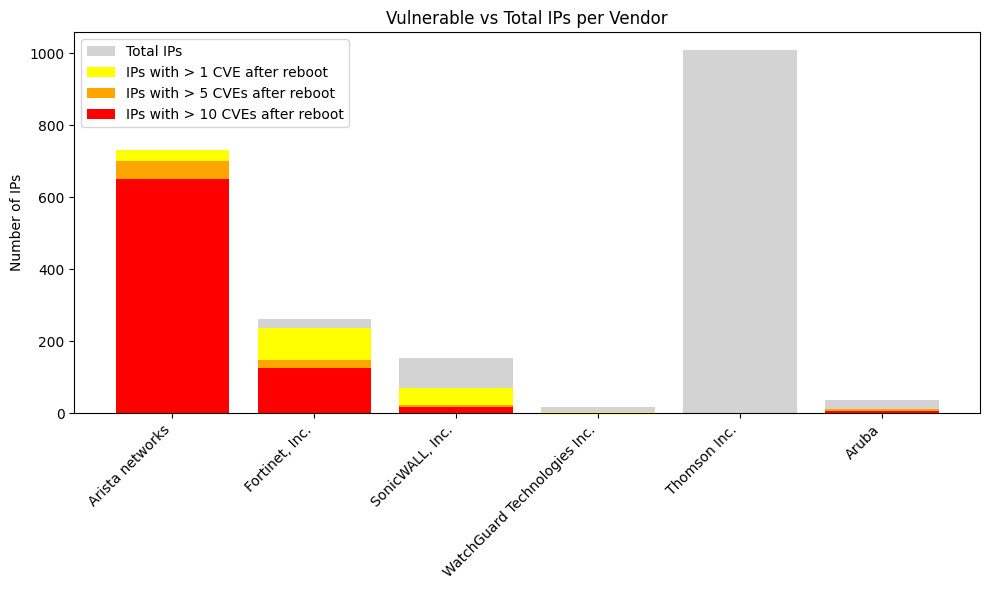

In [7]:
# Count the number of vulnerable IPs per vendor in the 'vendors' list
vendors_list = ["Arista networks", "Fortinet, Inc.", "SonicWALL, Inc.", "WatchGuard Technologies Inc.", "Thomson Inc.", "Aruba, a Hewlett Packard Enterprise company"]

# Define "vulnerable" as devices with a reboot date before today
df['Reboot_Datetime'] = pd.to_datetime(df['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
today = pd.Timestamp.now()
vulnerable_counts = {}
for v in vendors_list:
    df_vendor = df[df['Vendor'] == v]
    counts = [0,0,0]
    for ip, row in df_vendor.iterrows():
        reboot_date = row['Reboot_Datetime']
        # Check if there is at least one CVE published after the reboot date for this vendor
        cves_df = vendor_cves.get(v)
        if cves_df is not None and not cves_df.empty:
            cve_dates = pd.to_datetime(cves_df[cves_df['CVSS_Score'] > 4]['Published'], errors='coerce')
            num_cves = (cve_dates > reboot_date).sum()
            if num_cves > 1:
                counts[0] += 1
            if num_cves > 5:
                counts[1] += 1
            if num_cves > 10:
                counts[2] += 1

    vulnerable_counts[v] = counts

print("Vulnerable IPs per vendor:")
for v, counts in vulnerable_counts.items():
    print(f"{v}: {counts}")

print("\nTotal IPs per vendor:")
for v in vendors_list:
    num_ips = df[df['Vendor'] == v]['IP'].nunique()
    if v == "Aruba, a Hewlett Packard Enterprise company":
        print(f"{"Aruba"}: {num_ips}")
    else:
        print(f"{v}: {num_ips}")



# Prepare data for plotting
vendors_plot = list(vulnerable_counts.keys())
vulnerable_0 = [vulnerable_counts[v][0] for v in vendors_plot]
vulnerable_1 = [vulnerable_counts[v][1] for v in vendors_plot]
vulnerable_2 = [vulnerable_counts[v][2] for v in vendors_plot]
total = [df[df['Vendor'] == v]['IP'].nunique() for v in vendors_plot]

x = range(len(vendors_plot))
plt.figure(figsize=(10, 6))
plt.bar(x, total, label='Total IPs', color='lightgray')
plt.bar(x, vulnerable_0, label='Vulnerable IPs', color='yellow')
plt.bar(x, vulnerable_1, label='Vulnerable IPs', color='orange')
plt.bar(x, vulnerable_2, label='Vulnerable IPs', color='red')
vendors_plot[-1] = "Aruba"
plt.xticks(x, vendors_plot, rotation=45, ha='right')
plt.ylabel('Number of IPs')
plt.title('Vulnerable vs Total IPs per Vendor')
plt.legend([
    'Total IPs',
    'IPs with > 1 CVE after reboot',
    'IPs with > 5 CVEs after reboot',
    'IPs with > 10 CVEs after reboot'
])
plt.tight_layout()
plt.show()

In [12]:
vulnerable_counts = {}
for v in vendors_list:
    df_vendor = df[df['Vendor'] == v]
    cve_sum = 0
    for ip, row in df_vendor.iterrows():
        reboot_date = row['Reboot_Datetime']
        # Check if there is at least one CVE published after the reboot date for this vendor
        cves_df = vendor_cves.get(v)
        if cves_df is not None and not cves_df.empty:
            cve_dates = pd.to_datetime(cves_df[cves_df['CVSS_Score'] > 0]['Published'], errors='coerce')
            num_cves = (cve_dates > reboot_date).sum()
            cve_sum += num_cves
            

    vulnerable_counts[v] = cve_sum / df_vendor.shape[0]

print("Vulnerable IPs per vendor:")
for v, counts in vulnerable_counts.items():
    print(f"{v}: {counts}")


Vulnerable IPs per vendor:
Arista networks: 28.904109589041095
Fortinet, Inc.: 28.068702290076335
SonicWALL, Inc.: 3.207792207792208
WatchGuard Technologies Inc.: 0.6111111111111112
Thomson Inc.: 0.0
Aruba, a Hewlett Packard Enterprise company: 25.2972972972973
